# Example: Memory kernel extraction using data from ASE simulation

The "sim.py" script in this directory runs a short simulation of a Pt(111) surface slab, outputting the positions, velociites, and forces on each atom at each point in time. 

In this notebook, we analyze the output of the simulation and compute the memory or friction kernel on the metal surface sites. 

We then fit the memory kernel to a sum of exponentially damped sinusoids.

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from glepy.memory import time as memt

def calc_spectral(signals, scale):
    """
    Calculate spectral density of memory kernels by taking the absolute value
    of the real part of the fast fourier transform. 
    """
    output = []
    for i in range(len(signals)):
        f_i = np.abs( np.real( np.fft.fft(signals[i]) ) ) /scale
        output.append( f_i)
    return output
    
def harm3D(x, xeq, frck):
    """
    3D anisotropic harmonic potential.
    """
    x = (x - xeq)
    frc =  - np.einsum("ij,tdj->tdi",frck,x)
    return frc


npz = np.load("traj.npz")
pos,vel,frc = npz['pos'],npz['vel'],npz['frc']
Nsurface = np.size(pos,axis=1)

m = 195.084    # mass of platinum
dt = 0.005     # time interval between simulation frames
tcorr = 5000   # total number of timesteps for computing correlation functions
acc = frc/m

# Time Array 
t_arr = np.arange(0,tcorr)*dt

## Compute memory kernel from simulation data

Now we compute the memory kernel for the oscillation of surface sites within the lattice:

Each surface site in the lattice in obeys:
$$ m \ddot{x}(t) = -\frac{d W}{dx}(t) - \int_0^t K(t-\tau) \dot{x}(\tau) d\tau + R(t) $$

where $W$ is the potential of mean force. If multiply both sides by $\dot{x}(0)$ and take the equilibrium average:

$$ \left \langle \left[m \ddot{x}(t) + \frac{d W}{dx}(t) \right]  \dot{x}(0) \right \rangle = - \int_0^t K(t-\tau) \left \langle \dot{x}(\tau) \dot{x}(0) \right \rangle d\tau $$

Which we can simplify to:

$$ C_f(t) = - \int_0^t K(t-\tau) C_v(\tau) d\tau $$

where $C_f$ is a force-velocity correlation function and $C_v$ is the velocity-velocity autocorrelaiton function.

Temp = 2.7121 kJ/mol = 326.1955 Kelvin
Spring Constant for Potential of Mean Force (kJ/(mol A^2) 

[[ 99.   -4.9  -0.6]
 [ -4.9 152.6   0. ]
 [ -0.6   0.  308.8]]
calculating velocity tcfs
calculating force tcfs


/Users/ardavan/miniconda3/envs/ase_x86/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


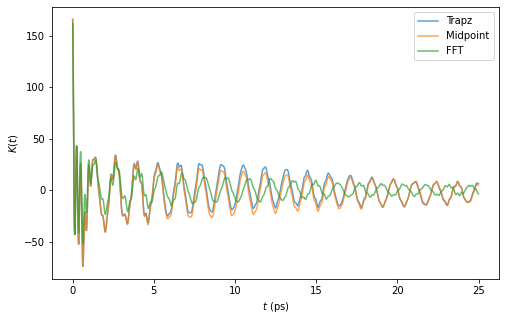

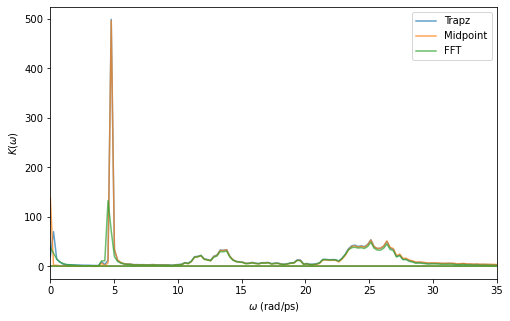

In [2]:
##### Bath (environment) averaged forces

# Calculate Temperature
kbT = m/3 * np.sum( np.mean( vel**2, axis=1), axis=1).mean()
print("Temp = %4.4f kJ/mol = %4.4f Kelvin"%(kbT, 120.2731 * kbT))

# Calculate Force Constants
pos_mean = np.mean(pos,axis=0)
frck_md = []
for i in range(Nsurface):
    frck_md.append( kbT * np.linalg.inv( np.cov( pos[:,i,:],rowvar=False) ) )
frck_md = np.array(frck_md)
print("Spring Constant for Potential of Mean Force (kJ/(mol A^2) \n")
print( np.array2string( frck_md.mean(axis=0).round(-1)/100) )

# Save Force Constants to File
file = open("./frck.dat",'w')
file.write("Temp = %4.4f kJ/mol = %4.4f Kelvin\n"%(kbT, 120.2731 * kbT))
file.write("Spring Constant for Potential of Mean Force (kJ/(mol A^2) \n")
file.write( np.array2string( frck_md.mean(axis=0).round(-1)/100) )
file.close()

# Calculate Bath Averaged Forces
dpmf_md = harm3D(pos, pos_mean, frck_md.mean(axis=0))

##### Calculate Time Correlation Functions

# Reshape arrays
pos_re = pos.reshape(-1,Nsurface*3)
vel_re = vel.reshape(-1,Nsurface*3)
frc_re = frc.reshape(-1,Nsurface*3)
acc_re = acc.reshape(-1,Nsurface*3)
dpmf_re = dpmf_md.reshape(-1,Nsurface*3)

# Calculate Velocity Correlation Functions
print("calculating velocity tcfs")
vel_tcf  = memt.calc_tcf(vel_re, vel_re, max_t=tcorr, mode="scipy")
dvel_tcf = -memt.calc_tcf(vel_re, acc_re, max_t=tcorr, mode="scipy")

# Forces Time Correlation Functions
print("calculating force tcfs")
frc_tcf      =  memt.calc_tcf(acc_re - dpmf_re/m, vel_re, max_t=tcorr, mode="scipy")
dfrc_tcf     = -memt.calc_tcf(acc_re - dpmf_re/m, acc_re, max_t=tcorr, mode="scipy")

# Extract z-components
vel_tcf_z   = vel_tcf[:,2::3].mean(axis=-1)
dvel_tcf_z   = dvel_tcf[:,2::3].mean(axis=-1)
frc_tcf_z   = frc_tcf[:,2::3].mean(axis=-1)
dfrc_tcf_z   = dfrc_tcf[:,2::3].mean(axis=-1)

##### Solve Volterra equation (memory kernel) using different methods
Ktz_t = memt.calc_memory_dtrapz(dvel_tcf_z, dfrc_tcf_z, vel_tcf_z[0], dt)
Ktz_m = memt.calc_memory_midpt(vel_tcf_z, frc_tcf_z, dt)
Ktz_f = memt.calc_memory_fft(vel_tcf_z, frc_tcf_z, dt)

#####  Plots

# Time
plt.figure(figsize=[8,5])
plt.plot(  t_arr,     Ktz_t, alpha= 0.7, label="Trapz")
plt.plot( (t_arr[1:] + t_arr[0:-1])/2, Ktz_m, alpha= 0.7, label="Midpoint")
plt.plot( t_arr[1:], Ktz_f[1:], alpha= 0.7, label="FFT")
plt.ylabel(r"$K(t)$")
plt.xlabel("$t$ (ps)")
plt.legend()

# Frequency Space
Kfz_t, Kfz_m, Kfz_f = calc_spectral([Ktz_t,Ktz_m,Ktz_f],scale=1/(2*dt))
freq_arr = 2 * np.pi * np.fft.fftfreq(n=tcorr,d=dt)

plt.figure(figsize=[8,5])
plt.plot(freq_arr, Kfz_t, label="Trapz", alpha=0.7)
plt.plot(freq_arr[0:-1], Kfz_m, label="Midpoint", alpha=0.7)
plt.plot(freq_arr, Kfz_f, label="FFT", alpha=0.7)
plt.ylabel(r"$K(\omega)$")
plt.xlabel(r"$\omega$ (rad/ps)")
plt.xlim(0,35)
plt.legend()

## Fit memory kernel to a sum of exponential sinusoids

Here we fit the memory kernel compute in the previous step to a sum of exponentially damped cosines. 

$$K(t) = \sum_j C_j e^{-\gamma_j t} \cos(\omega_j t)$$

We then cast this memory kernel into $A$ matrix form for future simulation in the "ase_gle.ipynb" script

$$K(t) = -\mathbf{A}_{vs} e^{-\mathbf{A}_{s}t} \mathbf{A}_{sv}$$

Coeffs of Terms (ps^-1):  [20.18 20.17 30.42 35.29 59.89]
Decay Rates (ps^-1):  [15.44  0.71  1.09  0.05  1.58]
Frequencies (ps^-1):  [33.82 26.41 13.37  4.78 24.45]


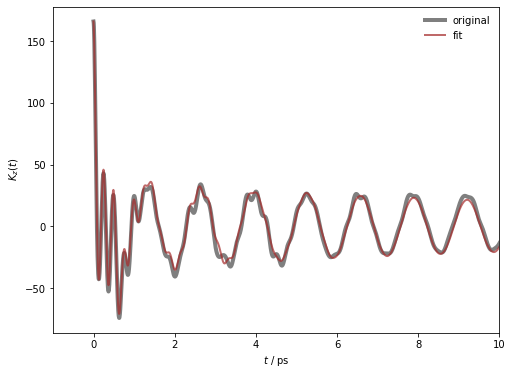

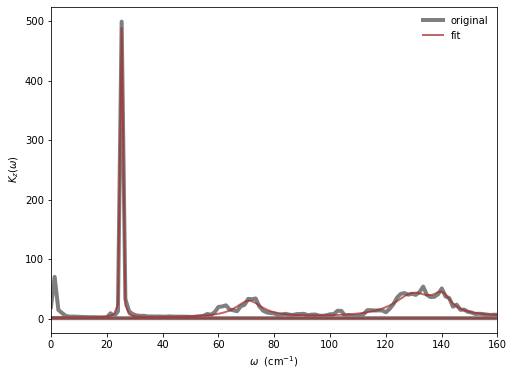

In [5]:
##### Fit Kz 

# Set number of terms in fit
nterm = 5

# Frequency conversion factor
radperps_to_cm = 33.356 * 1.0/(2*np.pi)
freq_cm      = freq_arr * radperps_to_cm # Frequency in units of cm-1

# Set Guess for Parameter valyes
coeffs_guess = [   40, 10, 10, 10, 10, 50, 50, 50, 50, 50 ]
decays_guess = [0.025, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
freqs_guess = [4, 10, 12, 15, 17, 22, 23, 24, 25, 26]

# Fit memory kernel
A = memt.Amatrix()
Ktz_fit, coeffs_fit, decays_fit, freqs_fit = A.fit(t_arr, Ktz_t, nterm, coeffs_guess, decays_guess, freqs_guess, bounds=(0.01,np.inf))
Kfz_fit = calc_spectral([Ktz_fit],scale=1/(2*dt))[0]

##### Plot
# Plot Time
plt.figure(figsize=[8,6])
plt.plot(t_arr, Ktz_t, linewidth=4, alpha=0.5, color="k")
plt.plot(t_arr, Ktz_fit, linewidth=2, alpha=0.7, color="brown")
plt.xlabel("$t$ / ps")
plt.ylabel(" $K_z(t)$ ")
plt.legend(["original","fit"],frameon=False)
plt.xlim(-1,10)

# Plot Frequency
plt.figure(figsize=[8,6])
plt.plot(freq_cm, Kfz_t, linewidth=4.0, alpha=0.5, color="k")
plt.plot(freq_cm, Kfz_fit, linewidth=2.0, alpha=0.7, color="brown")
plt.xlabel(r"$\omega$  (cm$^{-1})$")
plt.ylabel(r" $K_z(\omega)$ ")
plt.legend(["original","fit"],frameon=False)
plt.xlim(-0,160)

# Print and Output
print("Coeffs of Terms (ps^-1): ",coeffs_fit.round(2))
print("Decay Rates (ps^-1): ",decays_fit.round(2))
print("Frequencies (ps^-1): ",freqs_fit.round(2))

# Write Output
A.write_Amatrix("Kz_%dterm.A"%nterm)